# Packages Required

In [1]:
import pandas as pd
import numpy as np
import re
import pprint
from collections import defaultdict

import string
from string import punctuation

import os

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import gensim
from gensim import corpora, models, similarities

import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings("ignore")

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



# Time conversion of Tweets  

In [2]:
tweets = pd.read_csv(r'C:\Users\Luca Nannini\Desktop/TweetsClean.csv')
tweet = tweets[tweets['RT'] == False]
tweet

text  \
0       Hold on to your ass, hug your loved ones tight...   
2       It's time to Watch Trump destroy Secretary Cli...   
4       Drink every time Trump says huge folks #debate...   
6           This debate is going to get nasty real quick.   
7                          DEBATE TIME!!!!\nLETS GOOOOO!!   
8       On the one hand, America is a land of almost l...   
10      @millasauntie12 @realdonaldtrump is gonna dest...   
12      Been 15 months since I went to a Donald Trump ...   
13      lol watching the debate with my parents as the...   
14                                 Watching this debate 👀   
15      Bart Simpson is going to debate Lisa Simpson t...   
16                    this debate is gonna be interesting   
17      Tune into the first presidential debate tonigh...   
20              COME ON HILLARY 💙 #ImWithHer #debatenight   
21      Pretty surreal when you remember that Donald T...   
24                                        THE DEBATE 😍😍😍😍   
25      Watching the debate via @twitter #whatatimetob...   
26      Wizard of Oz Debate "Trump needs to show a bra...   
27      Idk why but I'm excited about this presidentia...   
28      #debatenight drinking game: take a shot whenev...   
29      Hillary and Donald switched colors apparently. 😂😂   
30      This debate is an hour and a half no commercia...   
32      i will not be watching the debate both of thes...   
34      Debate time! Hope you're as ready as we are fo...   
35          live pres debate I am ready for the pettiness   
37      My mom is only watching the debate because Les...   
38      #DebateNight will Africa feature anywhere in t...   
39      This debate is sponsored by the non-partisan d...   
40                   Does Hillary not have a middle name?   
41                                 IM WATCHING THE DEBATE   
...                                                   ...   
347287                                Omg. TRUMP STFU PLZ   
347293  Hillary came off as a bullshit politician, bec...   
347294  Oh please Trump you will be inappropriate some...   
347298  I mean I know Trump is being a terrifying idio...   
347306  Can we have a super cut of all the times Trump...   
347309  everyone is arguing about the debate and Im ov...   
347313  Trump needs to learn how to answer questions. ...   
347315  I wish I was sitting next to @Free_Tweets26 wa...   
347322  after watching this debate all I can say is #O...   
347323  Hillary is right is up to us...so vote for Jil...   
347324  Is Trump really not answering the question tha...   
347325                 That debate was pretty good tho. 👌   
347328  Holy f*ck this debate was a shitshow. It just ...   
347329  Hillary dropped that mic. #debate #debatenight...   
347332                         DONALD TRUMP IS THE DEVIL.   
347341  How can she attack Trump being against women w...   
347342  "He's not answering the fucking questions!!"\n...   
347343  Trump you one of them niggas that got a lot to...   
347344  The amount of cheering for Trump is very unset...   
347347  I couldn't watch the debate anymore because Tr...   
347348  I support democracy. Some time you win, some t...   
347352  "Friends don't let friends vote Trump!" - Hill...   
347355                                   Trump lost LMFAO   
347359                   Trump still is upset with Rosie?   
347364  Come on internet learn how to spell Hillary? I...   
347374                     Thank god this debate is over.   
347376  @LesterHoltNBC seems to be challenging Trump m...   
347379  all Trump is doing on that stage is denying an...   
347390  Watching &amp; listening very closely, Hillary...   
347392                    Trump ANSWERS THE DAMN Question   

                  created_at  geo lang  \
0       2016-09-27T01:04:53Z  NaN   en   
2       2016-09-27T01:04:53Z  NaN   en   
4       2016-09-27T01:04:53Z  NaN   en   
6       2016-09-27T01:04:53Z  NaN   en   
7       2016-09-27T01:04:53Z  NaN   en   
8       2016-09-27

In [3]:
#import datetime
from datetime import datetime
from datetime import timedelta

clean_timestamp =  tweet['created_at'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))
#offset in hours for EST timezone
offset_hours = -16
#account for offset from UTC using timedelta                                
local_timestamp = clean_timestamp + timedelta(hours=offset_hours)  

In [4]:
final_timestamp = local_timestamp.dt.strftime('%X')

In [5]:
#create a new dataframe with the new time format and tweets text
TIME = final_timestamp
TEXT = tweet['text']
new_tweet = pd.DataFrame(dict(TIME = TIME, TEXT = TEXT))
new_tweet.set_index("TIME", inplace= True)

In [ ]:
new_tweet

# Overall tweet volume & tweets LDA 

### Tweet Volume graph

In [ ]:
#nb. in order to visualize the tweet volume, the TIME column must be moved away as index. BUT for sub-chunk the new_tweet dataframe function should not be run.
new_tweet.reset_index(inplace= True)

In [ ]:
tweets_ratio = pd.to_datetime(new_tweet['TIME'], format='%X')

trace = go.Histogram(
    x=tweets_ratio,
    marker=dict(
        color='lightblue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Overall Debate',
    height=450,
    width=1200,
    xaxis=dict(
        title='Time Segment for each bar = 29sec'
    ),
    yaxis=dict(
        title='Tweet Volume'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Tweets LDA 

In [6]:
tweets = list(new_tweet.TEXT)

twtok = [
     [word for word in document.lower().split()]
      for document in tweets
 ]

# remove words that appear only once
frequency = defaultdict(int)
for text in twtok:
     for token in text:
        frequency[token] += 1
        
debtok = [
     [token for token in text if frequency[token] > 1]
     for text in twtok
 ]

In [18]:
tweets = [list(filter(None, [re.sub(r'\b\w{1,2}\b','', x) for x in y])) for y in
       debtok]
tweets = [list(filter(None, [re.sub(r'\d+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(@[A-Za-z0-9]+)','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[\.\,\'\"\!\?\:\;\-\_\/\=\(\)\|\*\&\@\#\$\"]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[^\x00-\x7F]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(.)\1{2,}',r'\1', x) for x in y])) for y in
       tweets]

In [19]:
stoplist1 = ['hillary','clinton','trump','donald','debatenight','debate','people','want','know','believe','you','really','lot','tell','young','stopandfrisk','that','get','got','much','many','put','kind','thanks','thank','think','well','nobody','take','taken','taking','going','go','things','maybe','something','yes','way','would','could','actually','almost','see','seen','sean','called','thing','let','done','went','say','whether','said','look','one','like','also','good','new','ever','little','cannot','everything','lester','even','hannity'] + list(stoplist)

In [20]:
lmtzr = WordNetLemmatizer()
stoplist = stopwords.words('english')
cleaned_tweets = [
     [lmtzr.lemmatize(word) for word in document if word not in stoplist1]
    for document in tweets
 ]

In [21]:
cleaned_tweets

[['hold', 'as', 'hug', 'loved', 'one', 'tight', 'hope', 'hrc', 'take'],
 ['time', 'watch', 'destroy', 'secretary', 'close', 'back', 'country', 'yeah'],
 ['drink', 'every', 'time', 'say', 'huge', 'folk', 'presidentialdebate'],
 ['nasty', 'real', 'quick'],
 ['time', 'let'],
 ['hand', 'america', 'land', 'hand', 'kid', 'line', 'stage'],
 ['gonna', 'destroy', 'tonight', 'everyone', 'trumptrain'],
 ['month', 'since', 'rally', 'laugh', 'crowd'],
 ['lol', 'watching', 'parent', 'support', 'gonna', 'fun'],
 ['watching'],
 ['bart', 'simpson', 'lisa', 'simpson', 'tonight'],
 ['gonna', 'interesting'],
 ['tune', 'first', 'presidential', 'tonight', 'crooked'],
 ['come', 'imwithher'],
 ['pretty', 'surreal', 'remember', 'american'],
 [],
 ['watching', 'via', 'whatatimetobealive'],
 ['wizard',
  'need',
  'show',
  'brain',
  'need',
  'show',
  'heart',
  'kay',
  'bbc',
  'news'],
 ['idk',
  'excited',
  'presidential',
  'saying',
  'man',
  'filter',
  'presidentialdebate'],
 ['drinking', 'game', 's

In [22]:
dictionary = corpora.Dictionary(cleaned_tweets)
corpus = [dictionary.doc2bow(text) for text in cleaned_tweets]

In [23]:
total_topics = 5
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)

In [24]:
lda.show_topics(total_topics,10)

[(0,
  '0.039*"time" + 0.031*"say" + 0.030*"debate" + 0.025*"talk" + 0.018*"every" + 0.015*"fact" + 0.013*"isi" + 0.012*"presidentialdebate" + 0.010*"lie" + 0.009*"iraq"'),
 (1,
  '0.035*"stamen" + 0.028*"debate" + 0.015*"stop" + 0.014*"experience" + 0.013*"fuck" + 0.013*"war" + 0.011*"talking" + 0.011*"nuclear" + 0.009*"joke" + 0.009*"minute"'),
 (2,
  '0.037*"debate" + 0.033*"president" + 0.030*"question" + 0.014*"answer" + 0.013*"bad" + 0.012*"saying" + 0.011*"make" + 0.011*"wrong" + 0.011*"great" + 0.010*"shit"'),
 (3,
  '0.031*"temperament" + 0.026*"debate" + 0.020*"lol" + 0.016*"win" + 0.015*"better" + 0.011*"support" + 0.011*"hilary" + 0.010*"winning" + 0.008*"tweet" + 0.008*"ad"'),
 (4,
  '0.025*"watching" + 0.023*"debate" + 0.021*"presidential" + 0.015*"vote" + 0.014*"word" + 0.012*"watch" + 0.010*"year" + 0.009*"everyone" + 0.009*"love" + 0.009*"mean"')]

### Tweets Semantic Heatmap

In [25]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [26]:
df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(107, 5)
(5, 107)


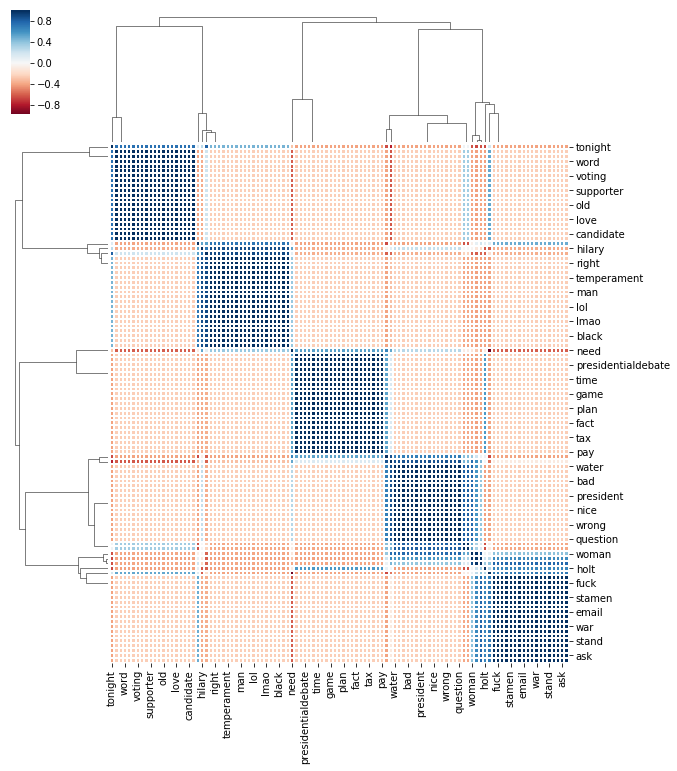

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=1, figsize=(10, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

### Tweets pyLDAvis

In [28]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds='TSNE')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       16.997576   -6.641399       1        1  21.820698
2      109.419350  -59.316898       2        1  21.008734
4        6.079795  -84.533577       3        1  20.853127
1       73.984360 -129.792038       4        1  19.319904
3       94.734924   18.185633       5        1  16.997545, topic_info=     Category         Freq                Term         Total  loglift  logprob
term                                                                          
14    Default  5669.000000                time   5669.000000  30.0000  30.0000
1765  Default  4531.000000              stamen   4531.000000  29.0000  29.0000
418   Default  4612.000000           president   4612.000000  28.0000  28.0000
22    Default  4516.000000                 say   4516.000000  27.0000  27.0000
1513  Default  3569.000000         temperament   3569.000000  26.0000  26.0000
421   Default  4318.000000            question   4318.000000  25.0000  25.0000
46    Default  3539.000000            watching   3539.000000  24.0000  24.0000
735   Default  3610.000000                talk   3610.000000  23.0000  23.0000
53    Default  2927.000000        presidential   2927.000000  22.0000  22.0000
43    Default  2295.000000                 lol   2295.000000  21.0000  21.0000
18    Default  2646.000000               every   2646.000000  20.0000  20.0000
746   Default  1930.000000                stop   1930.000000  19.0000  19.0000
340   Default  2019.000000              answer   2019.000000  18.0000  18.0000
3353  Default  1879.000000          experience   1879.000000  17.0000  17.0000
183   Default  1803.000000                 win   1803.000000  16.0000  16.0000
2926  Default  1955.000000                 isi   1955.000000  15.0000  15.0000
569   Default  2281.000000                fact   2281.000000  14.0000  14.0000
154   Default  1748.000000                fuck   1748.000000  13.0000  13.0000
3437  Default  1708.000000                 war   1708.000000  12.0000  12.0000
197   Default  2628.000000                vote   2628.000000  11.0000  11.0000
15    Default  1729.000000               watch   1729.000000  10.0000  10.0000
21    Default  1737.000000  presidentialdebate   1737.000000   9.0000   9.0000
1071  Default  1501.000000               wrong   1501.000000   8.0000   8.0000
78    Default  1489.000000               great   1489.000000   7.0000   7.0000
5855  Default  1447.000000             nuclear   1447.000000   6.0000   6.0000
606   Default  1473.000000                 lie   1473.000000   5.0000   5.0000
621   Default  2614.000000                word   2614.000000   4.0000   4.0000
45    Default  1353.000000             support   1353.000000   3.0000   3.0000
145   Default  1142.000000             winning   1142.000000   2.0000   2.0000
162   Default  1516.000000                year   1516.000000   1.0000   1.0000
...       ...          ...                 ...           ...      ...      ...
2832   Topic5   359.487793              nation    360.283966   1.7699  -5.7620
1873   Topic5   426.836975                fair    427.788757   1.7699  -5.5902
2376   Topic5   354.869537             telling    355.663025   1.7699  -5.7749
141    Topic5   353.318146               fight    354.116913   1.7698  -5.7793
85     Topic5   357.339569          commercial    358.148193   1.7698  -5.7679
416    Topic5   341.498474                read    342.293152   1.7698  -5.8133
234    Topic5   310.780304                code    311.593536   1.7695  -5.9075
756    Topic5   304.941925                 low    305.740265   1.7695  -5.9265
371    Topic5   303.137299                 tbh    303.931976   1.7695  -5.9324
857    Topic5   660.350586               funny    662.460754   1.7689  -5.1539
183    Topic5  1779.691772                 win   1803.772461   1.7587  -4.1624
1036   Topic5   483.409363                full    484.709045   1.7694  -5.4

### Tweets Debate Topic WordCloud

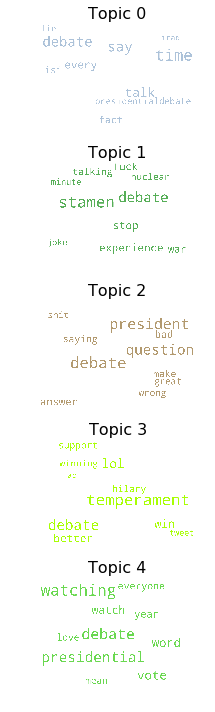

In [29]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2000,
                  height=1400,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### FastText Debate Word Embeddings 

In [34]:
from gensim.models import FastText
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

model = FastText(cleaned_tweets, size=100, window=50, min_count=500, workers=6)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:273: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:396: DeprecationWarning:

Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:400: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:409: DeprecationWarning:

Call to deprecated `min_n` (Attribute will be removed in 4.0.0, use wv.min_n instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:409: DeprecationWarning:

Call to deprecated `max_n` (Attribute will be removed in 4.0.0, use wv.max_n instead).

C:\Us

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).



C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\fasttext.py:411: DeprecationWarning:

Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).



FastText(vocab=268, size=100, alpha=0.025)


C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



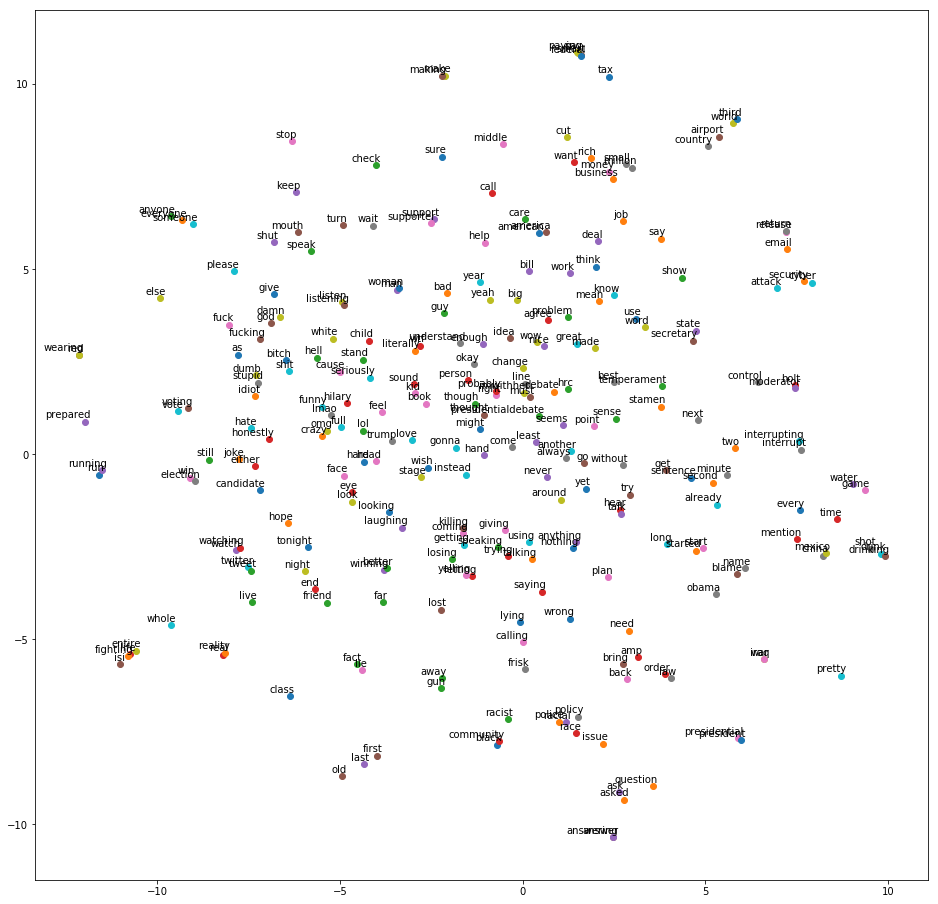

In [35]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model)

<br>

## Debate & Tweets Segment Time Frames

In tweets segments, +5 sec from the end of the final sentence expressed by a candidate is given before moving to the next one 

- Achieving Prosperity: jobs creation, bringing back expatriated American manufacturers, tax policy.
- Candidates private scandals: Trump’s tax return release, Clinton’s e-mails scandal.
- America’s Direction: healing race relations, police bias, Trump’s questioning Obama’s birth certificate legitimacy.
- Securing America: national institutions cyber attacks, ISIS, homegrown terroristic attacks, Iraq War, nuclear weapons policy.
- Mutual Acceptance & Election Outcome: Trump’s opinion on Clinton’s public figure, acceptance of election outcome.
 ***

### I° Segment, "Achieving Prosperity"

In [36]:
#define "Achieving Prosperity" segment
TW_I = new_tweet.loc['09:04:53':'09:31:23']
TW_I.reset_index(inplace= True)

In [37]:
TW_I_TIME = TW_I['TIME'] 

tweets_ratio_I = pd.to_datetime(TW_I_TIME, format='%X')

trace = go.Histogram(
    x=tweets_ratio_I,
    marker=dict(
        color='lightblue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='I. Achieving Prosperity',
    height=450,
    width=1200,
    xaxis=dict(
        title='Time Segment for each bar = 14sec'
    ),
    yaxis=dict(
        title='Tweet Volume'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [38]:
tweets1 = list(TW_I.TEXT)

twtok1 = [
     [word for word in document.lower().split()]
      for document in tweets1
 ]

# remove words that appear only once
frequency = defaultdict(int)
for text in twtok1:
     for token in text:
        frequency[token] += 1
        
debtok = [
     [token for token in text if frequency[token] > 1]
     for text in twtok1
 ]

In [41]:
tweets = [list(filter(None, [re.sub(r'\b\w{1,2}\b','', x) for x in y])) for y in
       debtok]
tweets = [list(filter(None, [re.sub(r'\d+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(@[A-Za-z0-9]+)','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[\.\,\'\"\!\?\:\;\-\_\/\=\(\)\|\*\@\#\$\"]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[^\x00-\x7F]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(.)\1{2,}',r'\1', x) for x in y])) for y in
       tweets]

lmtzr = WordNetLemmatizer()
stoplist = stopwords.words('english')
cleaned_tweets1 = [
     [lmtzr.lemmatize(word) for word in document if word not in stoplist1]
    for document in tweets
 ]

cleaned_tweets1

[['hold', 'as', 'hug', 'loved', 'one', 'tight', 'hope', 'hrc', 'take'],
 ['time', 'watch', 'destroy', 'secretary', 'close', 'back', 'country', 'yeah'],
 ['drink', 'every', 'time', 'say', 'huge', 'folk', 'presidentialdebate'],
 ['nasty', 'real', 'quick'],
 ['let'],
 ['hand', 'america', 'land', 'hand', 'kid', 'line', 'stage'],
 ['gonna', 'destroy', 'tonight', 'everyone', 'trumptrain'],
 ['month', 'since', 'rally', 'laugh', 'crowd'],
 ['lol', 'watching', 'parent', 'support', 'gonna', 'fun'],
 ['watching'],
 ['simpson', 'lisa', 'simpson', 'tonight'],
 ['gonna', 'interesting'],
 ['tune', 'first', 'presidential', 'tonight', 'crooked'],
 ['come', 'imwithher'],
 ['pretty', 'surreal', 'remember', 'american'],
 [],
 ['watching', 'via'],
 ['wizard', 'need', 'show', 'need', 'show', 'heart', 'news'],
 ['idk',
  'excited',
  'presidential',
  'saying',
  'man',
  'filter',
  'presidentialdebate'],
 ['drinking', 'game', 'shot', 'whenever', 'say', 'make', 'america', 'great'],
 ['switched', 'color', 'a

In [42]:
dictionary1 = corpora.Dictionary(cleaned_tweets1)

corpus1 = [dictionary1.doc2bow(text) for text in cleaned_tweets1]

In [43]:
total_topics = 3
lda = models.LdaModel(corpus1, id2word=dictionary1, num_topics=total_topics)

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.

C:\Users\Luca Nannini\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_i

In [44]:
lda.show_topics(total_topics,10)

[(0,
  '0.030*"debate" + 0.020*"watching" + 0.013*"presidential" + 0.010*"talking" + 0.009*"life" + 0.009*"interrupt" + 0.009*"fucking" + 0.009*"lol" + 0.009*"look" + 0.008*"president"'),
 (1,
  '0.024*"time" + 0.014*"talk" + 0.013*"interrupting" + 0.013*"shut" + 0.013*"every" + 0.012*"watch" + 0.011*"getting" + 0.010*"make" + 0.009*"minute" + 0.009*"need"'),
 (2,
  '0.054*"debate" + 0.016*"isi" + 0.016*"fact" + 0.013*"tax" + 0.011*"need" + 0.011*"plan" + 0.010*"job" + 0.010*"fighting" + 0.008*"question" + 0.007*"bad"')]

<br>

### II° Segment, "Candidate Figure Issues"

In [ ]:
Deb_II = list(first_debate.loc['09:31:38':'09:41:42'].TEXT)

In [ ]:
#define "Candidate Figure Issues" segment
TW_II = new_tweet.loc['09:31:38':'09:43:41']
TW_II.reset_index(inplace= True)

In [ ]:
TW_II_TIME = TW_II['TIME'] 

tweets_ratio_II = pd.to_datetime(TW_II_TIME, format='%X')

trace = go.Histogram(
    x=tweets_ratio_II,
    marker=dict(
        color='lightblue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='II. Candidate Figure Issues',
    height=450,
    width=1200,
    xaxis=dict(
        title='Time Segment for each bar = 9sec'
    ),
    yaxis=dict(
        title='Tweet Volume'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
tweets2 = list(TW_II.TEXT)

twtok2 = [
     [word for word in document.lower().split()]
      for document in tweets2
 ]

# remove words that appear only once
frequency = defaultdict(int)
for text in twtok2:
     for token in text:
        frequency[token] += 1
        
debtok2 = [
     [token for token in text if frequency[token] > 1]
     for text in twtok2
 ]

tweets = [list(filter(None, [re.sub(r'\b\w{1,2}\b','', x) for x in y])) for y in
       debtok2]
tweets = [list(filter(None, [re.sub(r'\d+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(@[A-Za-z0-9]+)','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[\.\,\'\"\!\?\:\;\_\-\/\=\(\)\|\*\@\&\#\$\"]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[^\x00-\x7F]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(.)\1{2,}',r'\1', x) for x in y])) for y in
       tweets]

lmtzr = WordNetLemmatizer()
cleaned_tweets2 = [
     [lmtzr.lemmatize(word) for word in document if word not in stoplist1]
    for document in tweets
 ]

cleaned_tweets2

In [ ]:
dictionary2 = corpora.Dictionary(cleaned_tweets2)
corpus2 = [dictionary2.doc2bow(text) for text in cleaned_tweets2]

In [ ]:
total_topics = 3
lda2 = models.LdaModel(corpus2, id2word=dictionary2, num_topics=total_topics)

lda2.show_topics(total_topics,10)

### III° Segment, "America's Direction"

In [ ]:
Deb_III = list(first_debate.loc['09:44:06':'10:04:10'].TEXT)

In [ ]:
#define "America's direction" segment
TW_III = new_tweet.loc['09:44:06':'10:06:14']
TW_III.reset_index(inplace= True)
TW_III_TEXT = list(TW_III.TEXT)


In [ ]:
TW_III_TIME = TW_III['TIME'] 

tweets_ratio_III = pd.to_datetime(TW_III_TIME, format='%X')

trace = go.Histogram(
    x=tweets_ratio_III,
    marker=dict(
        color='lightblue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title="III. America's Direction",
    height=450,
    width=1200,
    xaxis=dict(
        title='Time Segment for each bar = 14sec'
    ),
    yaxis=dict(
        title='Tweet Volume'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
tweets3 = list(TW_III.TEXT)

twtok3 = [
     [word for word in document.lower().split()]
      for document in tweets3
 ]

# remove words that appear only once
frequency = defaultdict(int)
for text in twtok3:
     for token in text:
        frequency[token] += 1
        
debtok2 = [
     [token for token in text if frequency[token] > 1]
     for text in twtok3
 ]

tweets = [list(filter(None, [re.sub(r'\b\w{1,2}\b','', x) for x in y])) for y in
       debtok2]
tweets = [list(filter(None, [re.sub(r'\d+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(@[A-Za-z0-9]+)','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[\.\,\'\"\!\?\:\;\-\_\/\=\(\)\|\*\&\@\#\$\"]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[^\x00-\x7F]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(.)\1{2,}',r'\1', x) for x in y])) for y in
       tweets]

lmtzr = WordNetLemmatizer()
cleaned_tweets3 = [
     [lmtzr.lemmatize(word) for word in document if word not in stoplist1]
    for document in tweets
 ]

cleaned_tweets3

In [ ]:
dictionary3 = corpora.Dictionary(cleaned_tweets3)
corpus3 = [dictionary3.doc2bow(text) for text in cleaned_tweets3]

In [ ]:
total_topics = 3
lda3 = models.LdaModel(corpus3, id2word=dictionary3, num_topics=total_topics)

lda3.show_topics(total_topics,10)

### IV° Segment, "Securing America"

In [ ]:
Deb_IV = list(first_debate.loc['10:06:26':'10:31:51'].TEXT)

In [ ]:
#define "Securing America" segment
TW_IV = new_tweet.loc['10:06:26':'10:33:00']
TW_IV.reset_index(inplace= True)
TW_IV_TEXT = list(TW_IV.TEXT)

In [ ]:
TW_IV_TIME = TW_IV['TIME'] 

tweets_ratio_IV = pd.to_datetime(TW_IV_TIME, format='%X')

trace = go.Histogram(
    x=tweets_ratio_IV,
    marker=dict(
        color='lightblue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='IV. Securing America',
    height=450,
    width=1200,
    xaxis=dict(
        title='Time Segment for each bar = 14sec'
    ),
    yaxis=dict(
        title='Tweet Volume'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
tweets4 = list(TW_IV.TEXT)

twtok4 = [
     [word for word in document.lower().split()]
      for document in tweets4
 ]

# remove words that appear only once
frequency = defaultdict(int)
for text in twtok4:
     for token in text:
        frequency[token] += 1
        
debtok4 = [
     [token for token in text if frequency[token] > 1]
     for text in twtok4
 ]

tweets = [list(filter(None, [re.sub(r'\b\w{1,2}\b','', x) for x in y])) for y in
       debtok4]
tweets = [list(filter(None, [re.sub(r'\d+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(@[A-Za-z0-9]+)','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[\.\,\'\"\!\?\:\;\-\_\/\=\(\)\|\*\&\@\#\$\"]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[^\x00-\x7F]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(.)\1{2,}',r'\1', x) for x in y])) for y in
       tweets]

lmtzr = WordNetLemmatizer()
cleaned_tweets4 = [
     [lmtzr.lemmatize(word) for word in document if word not in stoplist1]
    for document in tweets
 ]

cleaned_tweets4

In [ ]:
dictionary4 = corpora.Dictionary(cleaned_tweets4)
corpus4 = [dictionary4.doc2bow(text) for text in cleaned_tweets4]

In [ ]:
total_topics = 3
lda4 = models.LdaModel(corpus4, id2word=dictionary4, num_topics=total_topics)

lda4.show_topics(total_topics,10)

### V° Segment, "Mutual & Election Acceptance"

In [ ]:
Deb_V = list(first_debate.loc['10:33:04':'10:37:43'].TEXT)

In [ ]:
#define "Mutual and Election Acceptance"
TW_V = new_tweet.loc['10:33:04':'10:38:56']
TW_V_TEXT = list(TW_V.TEXT)
TW_V.reset_index(inplace= True)

In [ ]:
TW_V_TIME = TW_V['TIME'] 

tweets_ratio_V = pd.to_datetime(TW_V_TIME, format='%X')

trace = go.Histogram(
    x=tweets_ratio_V,
    marker=dict(
        color='lightblue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='V. Mutual and Election Acceptance',
    height=450,
    width=1200,
    xaxis=dict(
        title='Time Segment for each bar = 9sec'
    ),
    yaxis=dict(
        title='Tweet Volume'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
tweets5 = list(TW_V.TEXT)

twtok5 = [
     [word for word in document.lower().split()]
      for document in tweets5
 ]

# remove words that appear only once
frequency = defaultdict(int)
for text in twtok5:
     for token in text:
        frequency[token] += 1
        
debtok5 = [
     [token for token in text if frequency[token] > 1]
     for text in twtok5
 ]

tweets = [list(filter(None, [re.sub(r'\b\w{1,2}\b','', x) for x in y])) for y in
       debtok5]
tweets = [list(filter(None, [re.sub(r'\d+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(@[A-Za-z0-9]+)','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[\.\,\'\"\!\?\:\;\-\_\/\=\(\)\|\*\@\#\$\"]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'[^\x00-\x7F]+','', x) for x in y])) for y in
       tweets]
tweets = [list(filter(None, [re.sub(r'(.)\1{2,}',r'\1', x) for x in y])) for y in
       tweets]

lmtzr = WordNetLemmatizer()
cleaned_tweets5 = [
     [lmtzr.lemmatize(word) for word in document if word not in stoplist]
    for document in tweets
 ]

cleaned_tweets5

In [ ]:
dictionary5 = corpora.Dictionary(cleaned_tweets5)
corpus5 = [dictionary5.doc2bow(text) for text in cleaned_tweets5]

In [ ]:
total_topics = 2
lda5 = models.LdaModel(corpus5, id2word=dictionary5, num_topics=total_topics)

lda5.show_topics(total_topics,10)

***